In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn import preprocessing, metrics

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf


df_15_16 = pd.read_csv('data/bb_data_15_16.csv')
df_17 = pd.read_csv('data/bb_data_17.csv')
df_15_16 = df_15_16[list(df_15_16.columns[1:])]
df_17 = df_17[list(df_17.columns[1:])]
df_17.head()

,Name,Team,G,PA,HR,R,RBI,SB,BB%,K%,...,O-Contact_p,Z-Contact_p,Contact_p,Zone_p,F-Strike_p,SwStr_p,avg_hit_speed,barrels,brl_percent,avg_angle
0,Aaron Judge,Yankees,84.0,366.0,30.0,75.0,66.0,6.0,16.7,29.8,...,44.8,80.6,68.2,40.6,59.6,13.2,96.2,49.0,25.5,17.497848
1,Jose Altuve,Astros,86.0,380.0,13.0,62.0,50.0,18.0,9.7,12.1,...,76.5,91.4,85.3,41.1,67.4,6.8,85.3,21.0,7.2,10.461872
2,Mookie Betts,Red Sox,86.0,399.0,16.0,61.0,53.0,15.0,10.5,8.3,...,75.8,92.3,86.9,44.7,56.4,4.8,88.6,15.0,4.7,13.639279
3,Anthony Rendon,Nationals,81.0,339.0,16.0,46.0,54.0,5.0,14.2,13.9,...,75.3,92.3,87.7,46.6,59.9,5.1,89.9,18.0,7.5,21.013647
4,Paul Goldschmidt,Diamondbacks,88.0,381.0,20.0,73.0,67.0,13.0,15.0,20.2,...,66.5,80.2,76.0,45.4,59.3,10.4,92.2,32.0,13.3,15.365616


In [2]:
df_15_16.head()

,Name,Team,G,PA,HR,R,RBI,SB,BB%,K%,...,O-Contact_p,Z-Contact_p,Contact_p,Zone_p,F-Strike_p,SwStr_p,avg_hit_speed,barrels,brl_percent,avg_angle
0,Mike Trout,Angels,159.0,681.0,29.0,123.0,100.0,30.0,17.0,20.1,...,70.6,87.0,81.4,42.3,55.8,7.1,90.8,61,14.6,11.654219
1,Kris Bryant,Cubs,155.0,699.0,39.0,121.0,102.0,8.0,10.7,22.0,...,59.8,81.1,73.3,41.6,59.8,13.0,89.3,54,11.9,23.803787
2,Mookie Betts,Red Sox,158.0,730.0,31.0,122.0,113.0,26.0,6.7,11.0,...,71.6,94.8,87.3,47.6,60.8,5.2,89.6,31,5.2,16.929376
3,Josh Donaldson,Blue Jays,155.0,700.0,37.0,122.0,99.0,7.0,15.6,17.0,...,63.3,83.7,76.7,41.5,57.0,9.7,92.0,58,12.5,15.540617
4,Corey Seager,Dodgers,157.0,687.0,26.0,105.0,72.0,3.0,7.9,19.4,...,59.4,88.4,78.6,44.3,60.8,11.3,90.9,41,8.3,10.787186


### All data merged together from 2015 to 2016

We have data on players' hitting, power, plate discipline, and statcast averages

In [3]:
print(list(df_15_16.columns))

['Name', 'Team', 'G', 'PA', 'HR', 'R', 'RBI', 'SB', 'BB%', 'K%', 'ISO', 'BABIP', 'AVG', 'OBP', 'SLG', 'wOBA', 'wRC+', 'BsR', 'Off', 'Def', 'WAR', 'OPS', 'GB_per_FB', 'LD_p', 'GB_p', 'FB_p', 'IFFB_p', 'HR_per_FB', 'IFH', 'IFH_p', 'BUH', 'BUH_p', 'Pull_p', 'Cent_p', 'Oppo_p', 'Soft_p', 'Med_p', 'Hard_p', 'O-Swing_p', 'Z-Swing_p', 'Swing_p', 'O-Contact_p', 'Z-Contact_p', 'Contact_p', 'Zone_p', 'F-Strike_p', 'SwStr_p', 'avg_hit_speed', 'barrels', 'brl_percent', 'avg_angle']


### Traditional Stats:

1. AVG
2. R
3. RBI
4. HR
4. SB

### Post-Moneyball Advanced Stats:

1. OPS
2. ISO
3. BABIP
4. FB%
5. HR/FB

### Statcast Stats:

1. Exit Velocity
2. Launch Angle
3. Barrels/PA
4. Total Barrels

In [4]:
interest_cols = ['WAR', 'OPS' , 'OBP', 'SLG','G', 'PA', 'HR', 'R', 'RBI', 'SB', 
                 'ISO', 'BABIP', 'AVG', 'wOBA', 'wRC+', 'BsR', 'Off', 
                 'Def', 'GB_per_FB', 'LD_p', 'GB_p', 'FB_p', 'IFFB_p', 'HR_per_FB', 
                 'IFH', 'IFH_p', 'BUH', 'BUH_p', 'Pull_p', 'Cent_p', 'Oppo_p', 'Soft_p', 'Med_p', 
                 'Hard_p', 'O-Swing_p', 'Z-Swing_p', 'Swing_p', 'O-Contact_p', 'Z-Contact_p', 
                 'Contact_p', 'Zone_p', 'F-Strike_p', 'SwStr_p', 'avg_hit_speed', 'barrels', 
                 'brl_percent', 'avg_angle']
older_cols = ['AVG', 'HR', 'R', 'RBI', 'SB']
old_cols = ['OPS', 'ISO', 'BABIP','FB_p', 'HR_per_FB']
newer_cols = ['avg_hit_speed', 'avg_angle', 'brl_percent', 'barrels']

In [5]:
df_15_16[interest_cols].corr()

,WAR,OPS,OBP,SLG,G,PA,HR,R,RBI,SB,...,O-Contact_p,Z-Contact_p,Contact_p,Zone_p,F-Strike_p,SwStr_p,avg_hit_speed,barrels,brl_percent,avg_angle
WAR,1.000000,0.729554,0.694118,0.642891,0.303426,0.501040,0.406673,0.712878,0.423905,0.202839,...,0.047594,-0.015572,0.046793,-0.058754,-0.226035,-0.132951,0.282132,0.404291,0.322099,0.118990
OPS,0.729554,1.000000,0.824343,0.950777,0.221871,0.440241,0.692988,0.692724,0.692225,-0.047321,...,-0.093429,-0.152703,-0.125178,-0.359893,-0.398827,0.027981,0.635704,0.712236,0.654487,0.214730
OBP,0.694118,0.824343,1.000000,0.608349,0.119956,0.391857,0.251466,0.597514,0.343465,0.118968,...,0.108937,0.062626,0.131260,-0.197331,-0.459107,-0.272405,0.400367,0.348655,0.310628,-0.039079
SLG,0.642891,0.950777,0.608349,1.000000,0.245404,0.402725,0.833931,0.644135,0.782502,-0.131468,...,-0.190621,-0.248374,-0.247353,-0.396559,-0.307849,0.188344,0.672109,0.807716,0.747567,0.322448
G,0.303426,0.221871,0.119956,0.245404,1.000000,0.810952,0.387425,0.504106,0.454812,0.085217,...,-0.111568,-0.152916,-0.149449,-0.137795,-0.120758,0.119693,0.132626,0.359648,0.227891,0.181052
PA,0.501040,0.440241,0.391857,0.402725,0.810952,1.000000,0.449260,0.778460,0.544843,0.183395,...,0.022711,-0.038595,-0.003790,-0.125353,-0.185494,-0.046966,0.207731,0.425827,0.257600,0.166921
HR,0.406673,0.692988,0.251466,0.833931,0.387425,0.449260,1.000000,0.562335,0.831224,-0.269456,...,-0.404903,-0.476231,-0.489295,-0.441817,-0.273498,0.413156,0.663974,0.905483,0.858798,0.460279
R,0.712878,0.692724,0.597514,0.644135,0.504106,0.778460,0.562335,1.000000,0.541640,0.256650,...,-0.057704,-0.089302,-0.058218,-0.127290,-0.245398,-0.036793,0.320116,0.512156,0.397081,0.154254
RBI,0.423905,0.692225,0.343465,0.782502,0.454812,0.544843,0.831224,0.541640,1.000000,-0.252366,...,-0.181313,-0.269200,-0.267656,-0.387383,-0.277177,0.229839,0.646269,0.805122,0.704592,0.358435
SB,0.202839,-0.047321,0.118968,-0.131468,0.085217,0.183395,-0.269456,0.256650,-0.252366,1.000000,...,0.155238,0.150434,0.178965,0.214127,0.123028,-0.181182,-0.394137,-0.295040,-0.320145,-0.226062


### Visualizations

In [6]:
def hits_and_outs(year):
    df = pd.read_csv('data/savant_data_'+year+'.csv')
    df['Name'] = df['player_name']
    df['Result'] = [1 if x in ['single', 'double', 'triple', 'home_run'] else 0 for x in df['events']]
    df = df[['Name', 'launch_speed', 'launch_angle', 'events' ,'Result']]
    df = df[df['launch_speed'] != 'null']
    df['launch_speed'] = df['launch_speed'].astype(float)
    df['launch_angle'] = df['launch_angle'].astype(float)
    return df

def plot_hits_outs(df):
    plt.style.use('fivethirtyeight')

    hits = df[df['Result'] == 1]
    outs = df[df['Result'] == 0]
    
    singles = hits[hits['events']=='single']
    doubles = hits[hits['events']=='double']
    triples = hits[hits['events']=='triple']
    dingers = hits[hits['events']=='home_run']

    plt.figure(figsize=(15,10))
    plt.scatter(outs['launch_speed'], outs['launch_angle'], label='Outs', color='blue')
    plt.scatter(singles['launch_speed'], singles['launch_angle'], label='Singles', color = 'green')
    plt.scatter(doubles['launch_speed'], doubles['launch_angle'], label='Doubles', color = 'yellow')
    plt.scatter(triples['launch_speed'], triples['launch_angle'], label='Triples', color = 'orange')
    plt.scatter(dingers['launch_speed'], dingers['launch_angle'], label='Home Runs', color = 'red')
    
    #plt.title('Hits and Outs based on Launch Speed vs. Launch Angle')
    plt.xlabel('Launch Speed (MPH)')
    plt.ylabel('Launch Angle (degrees)')
    plt.legend(fontsize=16)
    plt.tick_params(labelsize=16)
    

In [7]:
from bokeh.charts import HeatMap, bins, show, vplot
from bokeh.palettes import YlOrRd9

df = hits_and_outs('2017').append(hits_and_outs('2016')).append(hits_and_outs('2015'))
plt.style.use('fivethirtyeight')

hits = df[df['Result'] == 1]
outs = df[df['Result'] == 0]

h1 = HeatMap(df, x=bins('launch_speed'), y=bins('launch_angle'), 
             values='Result', stat='mean',palette=YlOrRd9)

show(h1)

/Users/dev/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (53,54,75) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/Users/dev/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (2,14,27,28,29,30,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/Users/dev/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (2,14,27,28,29,30,50,51,53,54,75) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


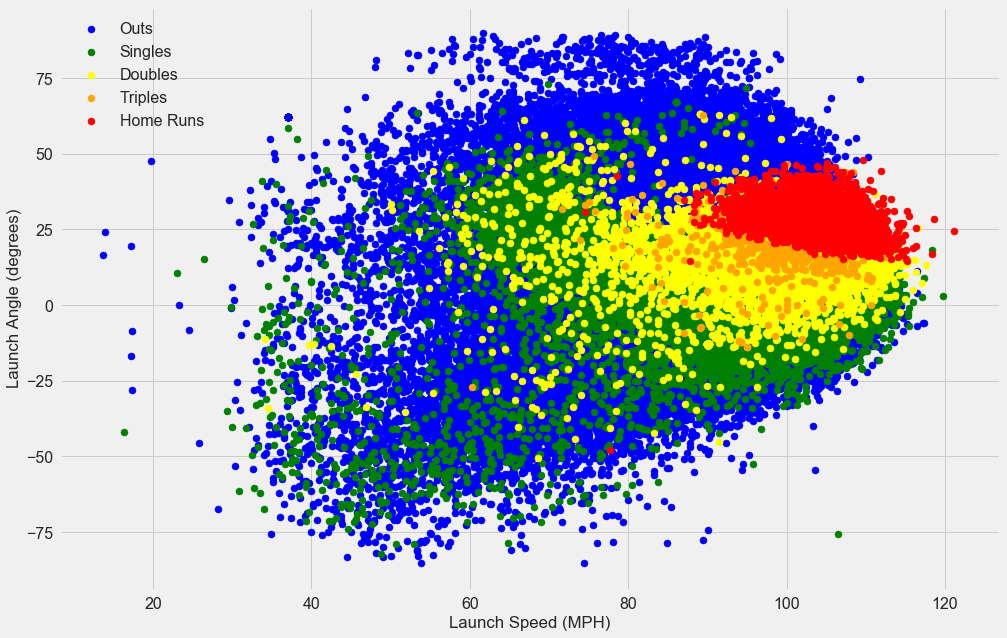

In [8]:
plot_hits_outs(df)

### Modeling

In [9]:
def model(clf, df, feat, target):
    X = df[feat]
    y = df[target]
    #min_max_scaler = preprocessing.MinMaxScaler()
    #X = min_max_scaler.fit_transform(X)
    X = (X-X.mean())/X.std()
    #X = pd.DataFrame(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    if clf in [RidgeCV(cv=5), LassoCV(cv=5)]:
        clf.fit(X_train, y_train)
        print(clf.score(X_test, y_test))
    else:
        #print(-cross_val_score(clf, X_test, y_test, cv=5, scoring='neg_mean_squared_error'))
        #print(-cross_val_score(clf, X_test, y_test, cv=5, scoring='neg_mean_squared_error').mean())
        print(cross_val_score(clf, X_test, y_test, cv=5, scoring='r2'))
        print(cross_val_score(clf, X_test, y_test, cv=5, scoring='r2').mean())
        clf.fit(X_train, y_train)
        
    pred = clf.predict(X_test)
    return y_test, pred

def plotter(y_test, pred, target):
    plt.scatter(y_test, pred)
    maxs = [max(y_test), max(pred)]
    mins = [min(y_test), min(pred)]
    plt.plot([min(mins),max(maxs)],[min(mins),max(maxs)], c='r')
    plt.tick_params(labelsize=16)
    plt.xlabel('Actual '+ target, fontsize=16)
    plt.ylabel('Pred ' + target, fontsize=16)

In [10]:
def normalize(df, feat, target):
    norm_df = df[feat]
    y = [x for x in df[target]]
    #min_max_scaler = preprocessing.MinMaxScaler()
    #norm_df = min_max_scaler.fit_transform(norm_df)
    norm_df = (norm_df-norm_df.mean())/norm_df.std()
    norm_df[target] = y
    return norm_df
    
def conv_cols(feat):
    return 'WAR ~ ' + ' + '.join(feat)

def stat_model(df, feat, target):
    norm_df = normalize(df, feat, target)
    y, X = patsy.dmatrices(conv_cols(feat), data=norm_df, return_type="dataframe")
    model = sm.OLS(y, X)
    fit = model.fit()
    return fit.summary()

In [11]:
y_test, pred = model(LinearRegression(), df_15_16, newer_cols, 'WAR')

[-0.03787334 -0.39393651 -0.00046881 -0.26678802  0.07534804]
-0.124743729


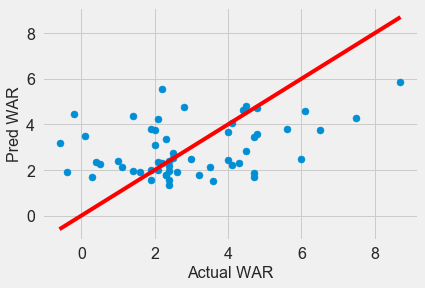

In [12]:
plotter(y_test, pred, 'WAR')

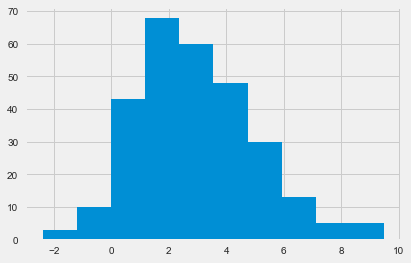

In [13]:
df_15_16['WAR'].hist()

In [14]:
y_test, pred = model(RidgeCV(cv=5), df_15_16, older_cols, 'WAR')

[ 0.50599238  0.55418747  0.1612036   0.72744462  0.59603414]
0.508972443863


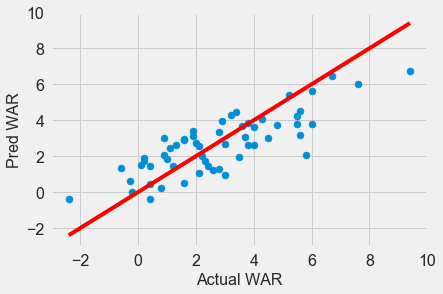

In [15]:
plotter(y_test, pred, 'WAR')

In [16]:
y_test, pred = model(LassoCV(cv=5), df_15_16, old_cols, 'WAR')

[ 0.02128465  0.39830018  0.5581879   0.66252893  0.70343312]
0.468746956785


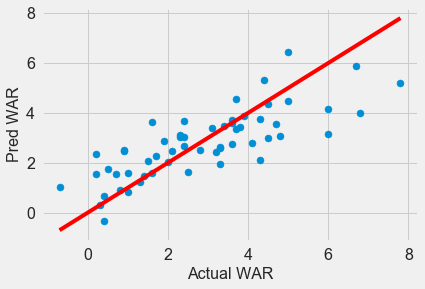

In [17]:
plotter(y_test, pred, 'WAR')

In [18]:
stat_model(df_15_16, older_cols, 'WAR')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    WAR   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     85.25
Date:                Sun, 16 Jul 2017   Prob (F-statistic):           3.92e-54
Time:                        13:23:58   Log-Likelihood:                -475.46
No. Observations:                 285   AIC:                             962.9
Df Residuals:                     279   BIC:                             984.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      2.9253      0.077     38.078      0.000         2.774     3.076
AVG            0.7684      0.096      8.010      0.000         0.580     0.957
HR             0.4711      0.165      2.852      0.005         0.146     0.796
R              0.9469      0.123      7.722      0.000         0.706     1.188
RBI           -0.1780      0.152     -1.173      0.242        -0.477     0.121
SB             0.0688      0.094      0.730      0.466        -0.117     0.255
==============================================================================
Omnibus:                        0.408   Durbin-Watson:                   1.225
Prob(Omnibus):                  0.816   Jarque-Bera (JB):                0.542
Skew:                           0.050   Prob(JB):                        0.763
Kurtosis:                       2.811   Cond. No.                         4.38
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
stat_model(df_15_16, old_cols, 'WAR')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    WAR   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     78.63
Date:                Sun, 16 Jul 2017   Prob (F-statistic):           3.04e-51
Time:                        13:23:58   Log-Likelihood:                -482.31
No. Observations:                 285   AIC:                             976.6
Df Residuals:                     279   BIC:                             998.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      2.9253      0.079     37.174      0.000         2.770     3.080
OPS            1.8404      0.231      7.956      0.000         1.385     2.296
ISO           -0.3384      0.408     -0.830      0.407        -1.141     0.464
BABIP          0.1903      0.134      1.421      0.157        -0.073     0.454
FB_p           0.2322      0.166      1.401      0.162        -0.094     0.559
HR_per_FB     -0.3371      0.220     -1.530      0.127        -0.771     0.097
==============================================================================
Omnibus:                        1.169   Durbin-Watson:                   1.189
Prob(Omnibus):                  0.558   Jarque-Bera (JB):                1.258
Skew:                           0.113   Prob(JB):                        0.533
Kurtosis:                       2.765   Cond. No.                         10.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
stat_model(df_15_16, newer_cols, 'WAR')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    WAR   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     21.16
Date:                Sun, 16 Jul 2017   Prob (F-statistic):           2.93e-15
Time:                        13:23:58   Log-Likelihood:                -569.97
No. Observations:                 285   AIC:                             1150.
Df Residuals:                     280   BIC:                             1168.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept         2.9253      0.107     27.380      0.000         2.715     3.136
avg_hit_speed    -0.0650      0.172     -0.377      0.706        -0.404     0.274
avg_angle        -0.0482      0.119     -0.404      0.687        -0.283     0.187
brl_percent      -2.0050      0.415     -4.832      0.000        -2.822    -1.188
barrels           2.8302      0.419      6.753      0.000         2.005     3.655
==============================================================================
Omnibus:                        1.664   Durbin-Watson:                   0.543
Prob(Omnibus):                  0.435   Jarque-Bera (JB):                1.430
Skew:                           0.165   Prob(JB):                        0.489
Kurtosis:                       3.105   Cond. No.                         9.05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

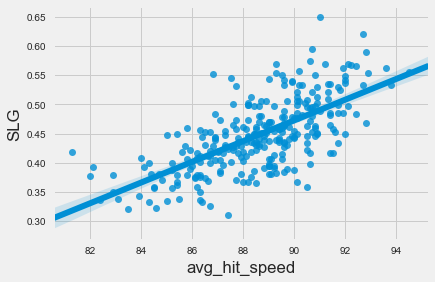

In [21]:
sns.regplot(x='avg_hit_speed', y='SLG', data=df_15_16)

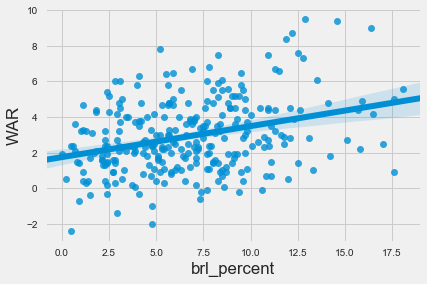

In [22]:
sns.regplot(x='brl_percent', y='WAR', data=df_15_16)

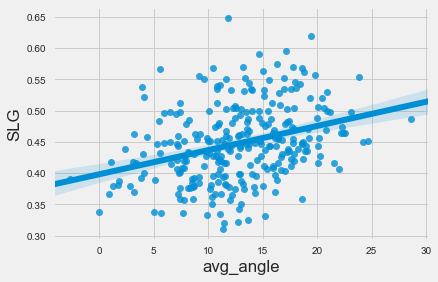

In [23]:
sns.regplot(x='avg_angle', y='SLG', data=df_15_16)

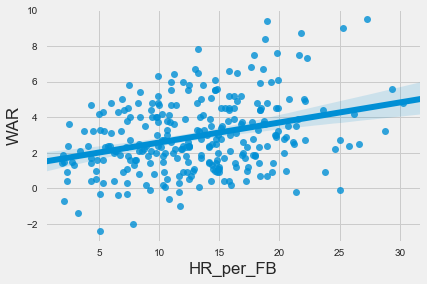

In [24]:
sns.regplot(x='HR_per_FB', y='WAR', data=df_15_16)

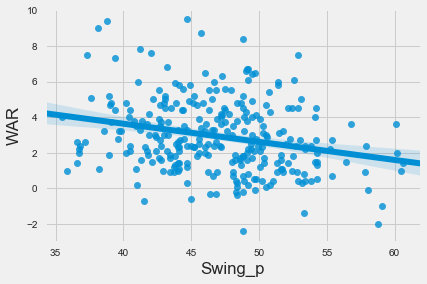

In [25]:
sns.regplot(x='Swing_p', y='WAR', data=df_15_16)

[ 0.61910023  0.63768467  0.50296715  0.6225578   0.46831942]
0.570125854303


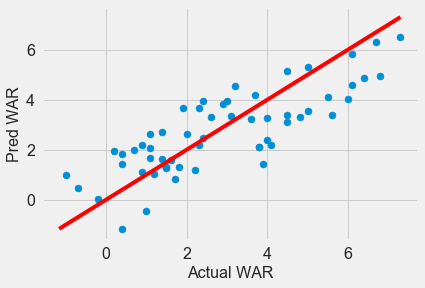

In [26]:
good_cols = ['OPS', 'brl_percent', 'R']
y_test, pred = model(LinearRegression(), df_15_16, good_cols, 'WAR')
plotter(y_test, pred, 'WAR')

### Feature Selection

Here I try modeling WAR using all available stats from scraping (except I excluded some that were essentially used in the equation to calculate WAR like wRC, etc.) 

I also use sklearns feature_selection to try creating a model that excludes features with high p-values.

This ends up not creating a much stronger model

In [27]:
all_cols = ['PA', 'HR', 'R', 'RBI', 'SB', 
                 'ISO', 'BABIP', 'AVG','GB_per_FB', 'LD_p', 'GB_p', 'FB_p', 'IFFB_p', 'HR_per_FB', 
                 'IFH', 'IFH_p', 'BUH', 'BUH_p', 'Pull_p', 'Cent_p', 'Oppo_p', 'Soft_p', 'Med_p', 
                 'Hard_p', 'O-Swing_p', 'Z-Swing_p', 'Swing_p', 'O-Contact_p', 'Z-Contact_p', 
                 'Contact_p', 'Zone_p', 'F-Strike_p', 'SwStr_p', 'avg_hit_speed', 'barrels', 
                 'brl_percent', 'avg_angle']

In [28]:
from sklearn import feature_selection as f_select

def selective_model(est, df, feat, target):
    X = df_15_16[feat]
    y = df_15_16[target]
    #min_max_scaler = preprocessing.MinMaxScaler()
    #X = min_max_scaler.fit_transform(X)
    X = (X-X.mean())/X.std()
    #X = pd.DataFrame(X)
    sig_columns=[]
    pvals=[]

    for feature in X.columns:
        #get pval on feature by feature basis
        pval=f_select.f_regression(X[[feature]],y)
        if pval[1][0]<.02: 
            sig_columns.append(feature)
            pvals.append(pval[1][0])
        
    X_trans=X[sig_columns]
    X_train, X_test, y_train, y_test = train_test_split(X_trans, y, test_size=0.2)
    print(cross_val_score(est,X_trans,y,cv=5,scoring='r2'))
    print(cross_val_score(est,X_trans,y,cv=5,scoring='r2').mean())
    print(list(zip(sig_columns, pvals)))
    #print(len(sig_columns))
    est.fit(X_train, y_train)
    pred = est.predict(X_test)
    return y_test, pred

[-2.01953771 -0.59312597 -0.36178972 -0.77172193 -0.97629971]
-0.944495007121


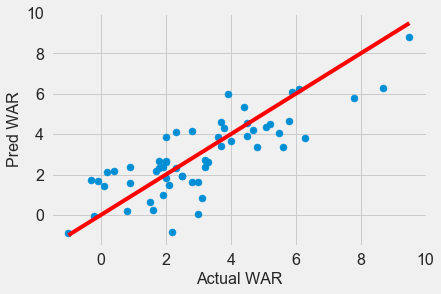

In [32]:
y_test, pred = model(LinearRegression(), df_15_16, all_cols, 'WAR')
plotter(y_test, pred, 'WAR')

[-0.20524278 -4.13469722  0.64989834 -1.51522823 -0.93423722]
-1.22790142288
[('PA', 1.6112190190853569e-19), ('HR', 8.9019348633623126e-13), ('R', 1.6211566474720134e-45), ('RBI', 7.3992924284174001e-14), ('SB', 0.00057072959496379022), ('ISO', 4.3688501052622298e-16), ('BABIP', 2.0233605641487149e-13), ('AVG', 6.6760081747754914e-25), ('GB_per_FB', 0.0058764409781817302), ('LD_p', 0.0018145353361737125), ('GB_p', 8.4073214731990116e-05), ('FB_p', 0.010784973213417043), ('HR_per_FB', 4.130312008213983e-08), ('IFH_p', 0.0095185304345107181), ('Soft_p', 4.7973409472045695e-07), ('Med_p', 0.00012135292580585704), ('Hard_p', 3.5809447036498947e-10), ('O-Swing_p', 9.0800590480928255e-07), ('Swing_p', 1.9999970606958568e-05), ('F-Strike_p', 0.00011856612375248599), ('avg_hit_speed', 1.2938198600295899e-06), ('barrels', 1.2416053255506132e-12), ('brl_percent', 2.6561816624714791e-08)]


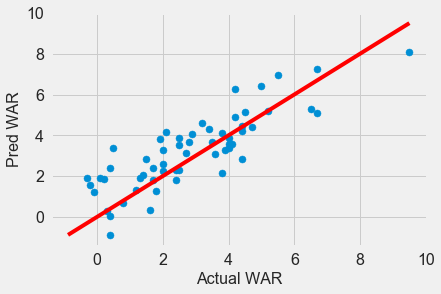

In [33]:
y_test, pred = selective_model(LinearRegression(), df_15_16, all_cols, 'WAR')
plotter(y_test, pred, 'WAR')

In [31]:
len(all_cols)

37